In [15]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import math
import shutil
import tqdm


In [16]:
CENTER = (int(2160/2)+100,1950)
CENTER_CV = (CENTER[1],CENTER[0])
HEIGHT = 2160
WIDTH = 3840
REFERENCES = [0, 32]
HIRE_DICT = {
    16: 16,
    8:8,
    4:4,
    2:2,
    1:1,
    3:1,
    6:2,
    5:1,
    7:1,
    12:4,
    10:2,
    9:1,
    11:1,
    14:2,
    13:1,
    15:1,
    24:8,
    20:4,
    18:2,
    17:1,
    19:1,
    22:2,
    21:1,
    23:1,
    28:4,
    26:2,
    25:1,
    27:1,
    30:2,
    29:1,
    31:1
}

sift_points_num_dict = {
    16:500,
    8:300,
    4:200,
    2:100,
    1:100,
}
static_H = np.diag((1.0,1.0,1.0))

In [17]:
def bounding(mask, pad = 0):
    mask = mask.astype("uint8")* 255
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Check if any contours were found
    if contours:
        x_min = 9999
        y_min = 9999
        x_max = 0
        y_max = 0
        for contour in contours:
        # Get the bounding rectangle of the largest contour
            x, y, w, h = cv2.boundingRect(contour)

            # Calculate min and max coordinates
            if x < x_min:
                x_min = x 
            if y < y_min:
                y_min = y
            if (y + h - 1) > y_max:
                y_max = (y + h - 1)
            if (x + w - 1) > x_max:
                x_max = (x + w - 1)

        return {'x_min': max(0,x_min- pad),
                'x_max': min(WIDTH, x_max+pad),
                'y_min': max(0, y_min-pad),
                'y_max': min(HEIGHT,y_max+pad)}
    else:
        raise RuntimeError("No contours found in the mask.")

def cropout(img, mask,):
    mydict = bounding(mask)
    img_ = img.copy()   
    img_[mask != True] =0
    img_ = img_[mydict['y_min']:mydict['y_max'],mydict['x_min']:mydict['x_max']]
    return img_

In [18]:
def calculate_angle(center, point):
    dx = point[0] - center[0]
    dy = point[1] - center[1]
    radians = np.arctan2(dy, dx)
    return radians
def get_point_on_ray(point, distance, direction = "forward"):
    if direction == "forward":
        angle_radians = calculate_angle(CENTER_CV, point)
        # 計算射線方向的單位向量
        direction = (np.cos(angle_radians), np.sin(angle_radians))
        # 尋找射線上距離中心點指定距離的點
        end_point = [point[0] + int(distance * direction[0]), 
                    point[1] + int(distance * direction[1])]
        # # 如果點超出邊界，將其調整為邊界點
        if 0 >= end_point[0]:
            end_point[0] = 0
        elif end_point[0] >= WIDTH:
            end_point[0] = WIDTH
        if 0 >= end_point[1]:
            end_point[1] = 0
        elif end_point[1] >= HEIGHT:
            end_point[1] = HEIGHT
    else:
        # 如果(x軸)靠近畫面中心，直接上下平移，以免導致畫面反而縮小
        if abs(point[0]- CENTER_CV[0]) < 600:
            if point[1] > CENTER_CV[1]:
                y = point[1]+400
            else:
                y = point[1]-100
            if point[0] > CENTER_CV[0]:
                x = point[0]-100
            else:
                x = point[0]+100
            return (x, y)
        angle_radians = calculate_angle(point, CENTER_CV)
        # 計算射線方向的單位向量
        direction = (np.cos(angle_radians), np.sin(angle_radians))
        # 尋找射線上距離中心點指定距離的點
        max_dist = euclidean_distance(point, CENTER_CV)
        distance = min(distance, max_dist-1)
        end_point = [point[0] + int(distance * direction[0]), 
                    point[1] + int(distance * direction[1])]
        # 如果點超出邊界，將其調整為邊界點
        if 0 >= end_point[0]:
            end_point[0] = 0
        elif end_point[0] >= WIDTH:
            end_point[0] = WIDTH
        if 0 >= end_point[1]:
            end_point[1] = 0
        elif end_point[1] >= HEIGHT:
            end_point[1] = HEIGHT    
    return end_point

In [19]:
def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

def find_intact_points_forward(contour, reference_point = CENTER_CV):
    if (contour['x_min'] <= CENTER_CV[0] <=  contour['x_max']) and (contour['y_min'] <= CENTER_CV[1] <=  contour['y_max']):
        points1 = [(contour['x_min'],contour['y_min']), (contour['x_max'],contour['y_min']), (contour['x_min'],contour['y_max']), (contour['x_max'],contour['y_max'])]
        points2 =[]
        return points1, points2
    points = [(contour['x_min'],contour['y_min']), (contour['x_max'],contour['y_min']), (contour['x_min'],contour['y_max']), (contour['x_max'],contour['y_max'])]
    # Calculate distances from the reference point
    distances = [(point, euclidean_distance(point, reference_point)) for point in points]
    # Sort based on distance
    distances.sort(key=lambda x: x[1])
    return [distances[2][0], distances[3][0]], [distances[0][0], distances[1][0]]

def find_intact_points_backward(contour, reference_point = CENTER_CV, pad = 50):
    # Calculate distances from the reference point
    if (contour['x_min'] <= CENTER_CV[0] <=  contour['x_max']) and (contour['y_min'] <= CENTER_CV[1] <=  contour['y_max']):
        contour= {'x_min': max(0,contour['x_min']- pad),
                'x_max': min(WIDTH, contour['x_max']+pad),
                'y_min': max(0, contour['y_min']-pad),
                'y_max': min(HEIGHT,contour['y_max']+pad)}
        points1 = []
        points2 = [(contour['x_min'],contour['y_min']), (contour['x_max'],contour['y_min']), (contour['x_min'],contour['y_max']), (contour['x_max'],contour['y_max'])]
        return points1, points2
    points = [(contour['x_min'],contour['y_min']), (contour['x_max'],contour['y_min']), (contour['x_min'],contour['y_max']), (contour['x_max'],contour['y_max'])]
    distances = [(point, euclidean_distance(point, reference_point)) for point in points]
    # Sort based on distance
    distances.sort(key=lambda x: x[1])
    intact = [distances[2][0], distances[3][0]]
    move = []
    for point in [distances[0][0], distances[1][0]]:
        if not (0 < point[0] < WIDTH) or not (0 < point[1] < HEIGHT):
            intact.append(point)
        else:
            move.append(point)
    return move, intact


# def cal_distance_rate(point, distance_rate=1, max = 500):
#     distance = euclidean_distance(CENTER_CV, point)
#     if distance < 100:
#         return min(math.log2(distance)*10*distance_rate, max)
#     else:
#         return min(distance*distance_rate, max)
    
# def get_ray_points(mask, direction= "forward", distance_rate = 1):
#     contour = bounding(mask, pad= 20)
#     if direction == "forward":
#         points1, points2 = find_intact_points_forward(contour)
#     else:
#         points1, points2 = find_intact_points_backward(contour)
    
#     result = []
#     for point in points1:
#         distance = cal_distance_rate(point, distance_rate)
#         if direction == "forward":
#             intersection = get_point_on_ray(point, distance)
#         else:
#             intersection = get_point_on_ray(point, distance, direction="backward")
#         result.append(tuple(map(int, intersection)))    
#     for point in points2:
#         result.append(tuple(map(int, point)))
#     return result

In [20]:
# def pick_diverse_points(points, features, num_points=300):
#     if len(points) <= num_points:
#         return points, features

#     points_pt = np.array([point.pt for point in points])
#     kmeans = KMeans(n_clusters=num_points)
#     kmeans.fit(points_pt)
#     centers = kmeans.cluster_centers_
#     labels = kmeans.labels_
#     selected_points = []
#     selected_features = []
#     for i in range(num_points): 
#         indexs = np.where(labels == i)[0]
#         n = random.randint(0, len(indexs)-1)
#         selected_points.append(points[indexs[n]])
#         selected_features.append(features[indexs[n]])
#     return selected_points, selected_features

In [21]:
# def get_distance_rate(frame_diff):
#     return (frame_diff+10)/20

def get_x_diff(y, frame_diff):
    return 250*((abs(y - CENTER_CV[1])+1200)/CENTER_CV[1])*frame_diff/16

def get_y_diff(x, frame_diff):
    return 250*((abs(x - CENTER_CV[0])+1500)/CENTER_CV[0])*frame_diff/16


In [22]:
def domask(reference, mask):
    masked_image = np.zeros_like(reference)
    masked_image[mask] = reference[mask]
    return masked_image
    
# def ray_mask(img, mask, direction = 'backward', distance_rate=1):
#     points = get_ray_points(mask,direction,distance_rate=distance_rate)
#     mask2 = np.zeros_like(img)
#     hull = cv2.convexHull(np.array(points))
#     cv2.fillConvexPoly(mask2, hull, (255))
#     masked_image = cv2.bitwise_and(img, mask2)
#     return masked_image

def ray_mask(img, mask, direction = 'backward', frame_diff=16, kernel_size = (25,25)):
    if frame_diff <= 4:
        frame_diff = 4
    if direction == 'forward':
        frame_diff = int(frame_diff*1.5)
    """find a bigger mask that may contain ROI by simply do dilation"""
    kernel = np.ones(kernel_size,np.uint8)
    mask = cv2.dilate(mask.astype('uint8')*255,kernel,iterations = frame_diff)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [23]:
def to_000(number):
    return f"000{str(number)}"[-3:]

def fill_black(img_to_fill, img2):
    """fill black pixels in img_to_fill with some point on img2"""
    mask = (img_to_fill == 0)
    img_to_fill[mask] = img2[mask]
    return img_to_fill

In [24]:
class Stitcher:
    def __init__(self, target_num ='016' ,frame_diff = 16 , mask = "mask_general.npy"):
        target_num =to_000(target_num)
        self.target = cv2.imread(f"frame/{target_num}.png",cv2.IMREAD_GRAYSCALE)
        self.target_num = target_num
        self.frame_diff = frame_diff
        self.reference_nums = [to_000(int(target_num)-frame_diff),to_000(int(target_num)+frame_diff) ]
        self.reference1 = cv2.imread(f"frame/{self.reference_nums[0]}.png",cv2.IMREAD_GRAYSCALE)
        self.reference2 = cv2.imread(f"frame/{self.reference_nums[1]}.png",cv2.IMREAD_GRAYSCALE)
        self.totalmask = np.load(mask)
        self.labelnum = (self.totalmask.max())+1
        self.canvas = np.zeros_like(self.target)
        self.warpdict = {}

    def detect_march_findH(self, target_masked, reference_masked, ratio = 0.75):
        # matches = self.orb_match(target_masked, reference_masked)
        # matches, matches_passed = self.check_match(matches)
        # if not matches_passed:
        src_pts, dst_pts, match_count = self.sift_match(target_masked, reference_masked)
        if match_count < 4:
            # self.drawMatches([reference_masked, target_masked], matches)
            print("no enough matched points to find H")
            return None
        else:
            H = self.fitHomoMat(src_pts, dst_pts)
            return H
    def search(self, target_masked, direction='backward',):
        reference_masked =ray_mask(self.reference2, self.mask, direction=direction, frame_diff=self.frame_diff)
        H = self.detect_march_findH(target_masked, reference_masked)
        return H, reference_masked
    def search_binary(self,target_masked,direction='backward', thres = 127):
        reference_masked =ray_mask(self.reference1, self.mask, direction=direction,frame_diff=self.frame_diff)
        _, target_binary = cv2.threshold(target_masked,thres,255,cv2.THRESH_BINARY)
        _, reference_binary = cv2.threshold(reference_masked,thres,255,cv2.THRESH_BINARY)
        H = self.detect_march_findH(target_binary, reference_binary)
        return H, reference_masked
    def sift_match(self,img1,img2):
        sift = cv2.SIFT_create(sift_points_num_dict[self.frame_diff])
        
        # find the keypoints and descriptors with SIFT
        kp1, des1 = sift.detectAndCompute(img1,None)
        kp2, des2 = sift.detectAndCompute(img2,None)
        
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        
        matches = flann.knnMatch(des1,des2,k=2)
        
        # store all the good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < 0.5*n.distance:
                good.append(m)
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        return src_pts, dst_pts, len(good)

    def stitch(self, label):
        '''
            Match points and find H and store in dict, label-wise
        '''
        # Step0 - mask
        self.mask =  (self.totalmask == label)
        self.warpdict[label]= {}
        if self.mask.sum() == 0:
            return
        
        if label == 8: # the lower static part do directly paste
            self.warpdict[label]['backward'] = {'available': True,"H":static_H, 'mask': self.mask, 'reference_num':self.reference_nums[0], 'reference':domask(self.reference1, self.mask)}
            self.warpdict[label]['forward'] = {'available': True,"H":static_H, 'mask': self.mask, 'reference_num':self.reference_nums[1], 'reference':domask(self.reference1, self.mask)}
            return self.warpdict[label]
        if label ==0:
            self.warpdict[label]['backward'] = {'available': False,"H":static_H, 'mask': self.mask, 'reference_num':self.reference_nums[0], 'reference':domask(self.reference1, self.mask)}
            self.warpdict[label]['forward'] = {'available': False,"H":static_H, 'mask': self.mask, 'reference_num':self.reference_nums[1], 'reference':domask(self.reference1, self.mask)}
            return self.warpdict[label]

        target_masked =domask(self.target, self.mask)

        forward_H, forward_reference_masked = self.search(target_masked, direction= 'forward')
        backward_H, backward_reference_masked = self.search(target_masked, direction= 'backward')

        if isinstance(forward_H, np.ndarray):
            self.warpdict[label]['forward'] = {'available': True,"H":forward_H, 'mask': self.mask, 'reference_num':self.reference_nums[1], 'reference':forward_reference_masked}
        else:
            self.warpdict[label]['forward'] ={'available': False ,"H":forward_H, 'mask': self.mask, 'reference_num':self.reference_nums[1], 'reference':forward_reference_masked}
        
        if isinstance(backward_H, np.ndarray):
            self.warpdict[label]['backward'] = {'available': True,"H":backward_H, 'mask': self.mask, 'reference_num':self.reference_nums[0], 'reference':backward_reference_masked}
        else:
            self.warpdict[label]['backward'] ={'available': False ,"H":backward_H, 'mask': self.mask, 'reference_num':self.reference_nums[0], 'reference':backward_reference_masked}
        return self.warpdict[label]
    
    def warp_and_paste(self):
        for label in self.warpdict.keys():
            if label == 0:
                if self.warpdict[1]['backward']['available'] == True:
                    self.warpdict[0]['backward']['H'] =  self.warpdict[1]['backward']['H'] 
                    self.warpdict[0]['backward']['available'] =  self.warpdict[1]['backward']['available'] 
                if self.warpdict[1]['forward']['available'] == True:
                    self.warpdict[0]['forward']['H'] =  self.warpdict[1]['forward']['H'] 
                    self.warpdict[0]['forward']['available'] =  self.warpdict[1]['forward']['available'] 
            current_warpdict = self.warpdict[label]
            mask = current_warpdict['backward']['mask']
            warped_imgs = self.warp(current_warpdict)
            if not bool(warped_imgs):
                continue
            warp_img = self.linear_blending(warped_imgs, current_warpdict, mask)
            self.canvas[mask] = warp_img[mask]
        return self.canvas
    
    def cal_alpha(self, images1, images2):
        """set alpha weight based on image pixel diversity?"""
        alpha = 0.5
        beta = (1.0 - alpha)
        return alpha, beta
        
    def linear_blending(self, images, warpdict, mask):
        if len(images) == 1:
            return domask(images[0], mask)
        images[0] = fill_black(images[0], images[1])
        images[1] = fill_black(images[1], images[0])
        alpha, beta = self.cal_alpha(images[0], images[1])
        dst = cv2.addWeighted(images[0], alpha, images[1], beta, 0.0)
        return domask(dst, mask)
    # def check_match(self, matches, thres = 0.65):
        if len(matches) < 4:
            return matches, False
        """Check if the match points are mostly horizontial. delete matches with crazy y difference"""
        checked_match = []
        n =0
        for p1, p2 in matches:
            x1, y1 = p1
            x2, y2 = p2
            x_diff = get_x_diff(y1, self.frame_diff)
            y_diff = get_y_diff(x1, self.frame_diff)
            # print( (x1, y1), abs(x1-x2), x_diff, abs(y1-y2), y_diff)
            if abs(x1-x2) < x_diff and abs(y1-y2) < y_diff:
                checked_match.append((p1,p2))
                n+=1
        if n/len(matches) < thres:
            return checked_match, False
        return checked_match, True

    # def orb_match(self,img1, img2, max_match = 50):
        """do point metch with ORB(fast)"""
        orb = cv2.ORB_create()
        kp1, des1 = orb.detectAndCompute(img1, None) # queryImage
        kp2, des2 = orb.detectAndCompute(img2, None) # trainImage
        if not isinstance(des1, np.ndarray) or not  isinstance(des2, np.ndarray):
            return []
        # calculate the matched points by estimating the distance bwtween descriptors
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(des1, des2)
        print("match points: ", len(matches))
        max_match = min(max_match, len(matches))
        matches = matches[:max_match]
        q_idx = [match.queryIdx for match in matches]
        t_idx = [match.trainIdx for match in matches]
        # use the index to find corresponding keypoints
        src_pts = np.array([kp1[idx].pt for idx in q_idx])
        dst_pts = np.array([kp2[idx].pt for idx in t_idx])
        matches = []
        for i in range(len(dst_pts)):
            matches.append([src_pts[i], dst_pts[i]])
        matches =np.array(matches, dtype = "int")
        return matches
    
    def fitHomoMat(self, srcPoints, dstPoints):
        '''
            Fit the best homography model with RANSAC algorithm - noBlending、linearBlending、linearBlendingWithConstant
        '''
        H, _ = cv2.findHomography(srcPoints, dstPoints, cv2.RANSAC, 5.0)
        if not isinstance(H, np.ndarray):
            H, _ = cv2.findHomography(srcPoints, dstPoints, method=0)
        return H
    
    def warp(self, warpdict):
        '''
        Return a pair of warped image 
        '''
        b_dict = warpdict['backward']
        f_dict = warpdict['forward']
        result = []
        if b_dict['available']:
            result.append(cv2.warpPerspective(b_dict['reference'], b_dict['H'], ( WIDTH, HEIGHT,)))
        if f_dict['available']:
            result.append(cv2.warpPerspective(f_dict['reference'], f_dict['H'], ( WIDTH, HEIGHT,), flags = cv2.WARP_INVERSE_MAP))
        return result

In [25]:
def to32(num:int):
    while num > 32:
        num -= 32
    return num

In [27]:
# main
if not os.path.exists('results'):
    os.mkdir('results')

for i in tqdm.tqdm(range(129)):
    if to32(i) in REFERENCES:
        print(f"copy {to_000(i)}.png")
        shutil.copyfile(f"frame/{to_000(i)}.png", f"results/{to_000(i)}.png")
        continue
    print(f"generating {to_000(i)}.png with frame_diff {HIRE_DICT[to32(i)]}")
    stitcher = Stitcher(target_num =i ,frame_diff = HIRE_DICT[to32(i)],mask = "mask_general.npy")
    for j in range(stitcher.labelnum):
        stitcher.stitch(j)
    result = stitcher.warp_and_paste()
    cv2.imwrite(f"results/{to_000(i)}.png", result)

  0%|          | 0/129 [00:00<?, ?it/s]

copy 000.png
generating 001.png with frame_diff 1


  2%|▏         | 2/129 [00:45<48:34, 22.95s/it]

generating 002.png with frame_diff 2


  2%|▏         | 3/129 [01:29<1:06:35, 31.71s/it]

generating 003.png with frame_diff 1


  3%|▎         | 4/129 [02:13<1:15:02, 36.02s/it]

generating 004.png with frame_diff 4


  4%|▍         | 5/129 [02:57<1:20:32, 38.97s/it]

generating 005.png with frame_diff 1


  5%|▍         | 6/129 [03:39<1:22:08, 40.07s/it]

generating 006.png with frame_diff 2


  5%|▌         | 7/129 [04:23<1:23:55, 41.27s/it]

generating 007.png with frame_diff 1


  6%|▌         | 8/129 [05:08<1:25:45, 42.52s/it]

generating 008.png with frame_diff 8


  7%|▋         | 9/129 [05:50<1:24:24, 42.21s/it]

generating 009.png with frame_diff 1


In [ ]:
def drawMatches(imgs, src_pts, dst_pts):
    '''
        Draw the match points img with keypoints and connection line
    '''
    
    # initialize the output visualization image
    img_left, img_right = imgs
    img_left = cv2.cvtColor(img_left,cv2.COLOR_GRAY2BGR)
    img_right = cv2.cvtColor(img_right,cv2.COLOR_GRAY2BGR)
    vis = np.zeros((HEIGHT, WIDTH*2, 3), dtype="uint8")
    vis[0:HEIGHT, 0:WIDTH] = img_left
    vis[0:HEIGHT, WIDTH:] = img_right
    
    # Draw the match
    for (img_left_pos, img_right_pos) in zip(src_pts, dst_pts):
            pos_l = img_left_pos[0].astype('int')
            pos_r = img_right_pos[0][0].astype('int') + WIDTH, img_right_pos[0][1].astype('int')
            cv2.circle(vis, pos_l, 3, (0, 0, 255), 1)
            cv2.circle(vis, pos_r, 3, (0, 255, 0), 1)
            cv2.line(vis, pos_l, pos_r, (255, 0, 0), 3)
            
    # return the visualization
    plt.figure(4)
    plt.title("img with matching points")
    plt.imshow(vis[:,:,::-1])
    #cv2.imwrite("Feature matching img/matching.jpg", vis)
    return vis

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

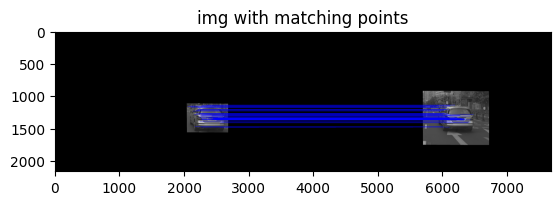

In [ ]:
target_masked = domask(stitcher.target, maskall==1)
reference_masked = ray_mask(stitcher.target, maskall==1)
src_pts, dst_pts, match_count = stitcher.sift_match(target_masked, reference_masked)
drawMatches(imgs=[target_masked, reference_masked],src_pts=src_pts, dst_pts=dst_pts )

In [ ]:
src_pts

array([[[1864.9921, 1564.9445]],

       [[1864.9921, 1564.9445]],

       [[2874.7769, 1344.3617]],

       [[2874.7769, 1344.3617]],

       [[2897.5037, 1348.2981]],

       [[2941.8113, 1356.1547]],

       [[2941.8113, 1356.1547]],

       [[3033.3928, 1372.089 ]],

       [[3071.2002, 1379.2277]],

       [[3071.2002, 1379.2277]]], dtype=float32)

In [ ]:
label = 8
print( stitcher.warpdict[label]['backward']['H'], stitcher.warpdict[label]['forward']['H'],)
plt.subplot(321)
plt.imshow(domask(stitcher.target, stitcher.warpdict[label]['backward']['mask']))
plt.subplot(323)
# plt.imshow(stitcher.warpdict[label]['backward']['reference'])
plt.imshow(ray_mask(stitcher.warpdict[label]['backward']['reference'],stitcher.warpdict[label]['backward']['mask']))
plt.subplot(324)
plt.imshow(stitcher.warp(stitcher.warpdict[label])[0])
plt.subplot(325)
plt.imshow(ray_mask(stitcher.warpdict[label]['forward']['reference'],stitcher.warpdict[label]['forward']['mask']))
# plt.imshow(stitcher.warpdict[label]['forward']['reference'])
plt.subplot(326)
plt.imshow(stitcher.warp(stitcher.warpdict[label])[1])


KeyError: 8